In [1]:
import torch

torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"


In [15]:
class CNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2):
        super(CNNLayer, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class CNNTransposeLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2):
        super(CNNTransposeLayer, self).__init__()

        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [40]:
color_chans = 1

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(color_chans, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # 64 channels * 7 * 7 spatial dimensions = 3136
        self.linear_mu = nn.Linear(64 * 7 * 7, latent_dims)
        self.linear_sigma = nn.Linear(64 * 7 * 7, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        
    def forward(self, x):
        x = self.encoder(x)
        # Flatten: [B, 64, 7, 7] → [B, 3136]
        x = x.view(x.size(0), -1)
        
        mu = self.linear_mu(x)
        sigma = torch.exp(self.linear_sigma(x))
        
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        
        self.decoder_input = nn.Linear(latent_dims, 64 * 7 * 7)  # Back to 64 channels * 7 * 7 spatial
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, color_chans, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    
    def forward(self, z):
        # z: [B, latent_dims]
        z = self.decoder_input(z)
        # Reshape: [B, 3136] → [B, 64, 7, 7]
        z = z.view(z.size(0), 64, 7, 7)
        z = self.decoder(z)
        return z

In [41]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [42]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.AdamW(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        total_loss = 0
        for x, y in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)

            loss = ((x - x_hat) ** 2).sum() + autoencoder.encoder.kl
            total_loss += loss.item()
            loss.backward()
            opt.step()

        print(f"Loss: {total_loss / len(data)}")

    return autoencoder

In [43]:
latent_dims = 2
autoencoder = VariationalAutoencoder(latent_dims).to(device)  # GPU

data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "./data", transform=torchvision.transforms.ToTensor(), download=True
    ),
    batch_size=128,
    shuffle=True,
)

vae = VariationalAutoencoder(latent_dims).to(device)  # GPU
vae = train(vae, data)

Epoch 0
Loss: 6597.986859091818
Epoch 1
Loss: 5593.574924623534
Epoch 2
Loss: 5451.649573352545
Epoch 3
Loss: 5383.078215576693
Epoch 4
Loss: 5337.9075076625795
Epoch 5
Loss: 5297.849114847081
Epoch 6
Loss: 5267.1441762310105
Epoch 7
Loss: 5239.805128931237
Epoch 8
Loss: 5207.245168722515
Epoch 9
Loss: 5181.020525511394
Epoch 10
Loss: 5159.388473022721
Epoch 11


KeyboardInterrupt: 

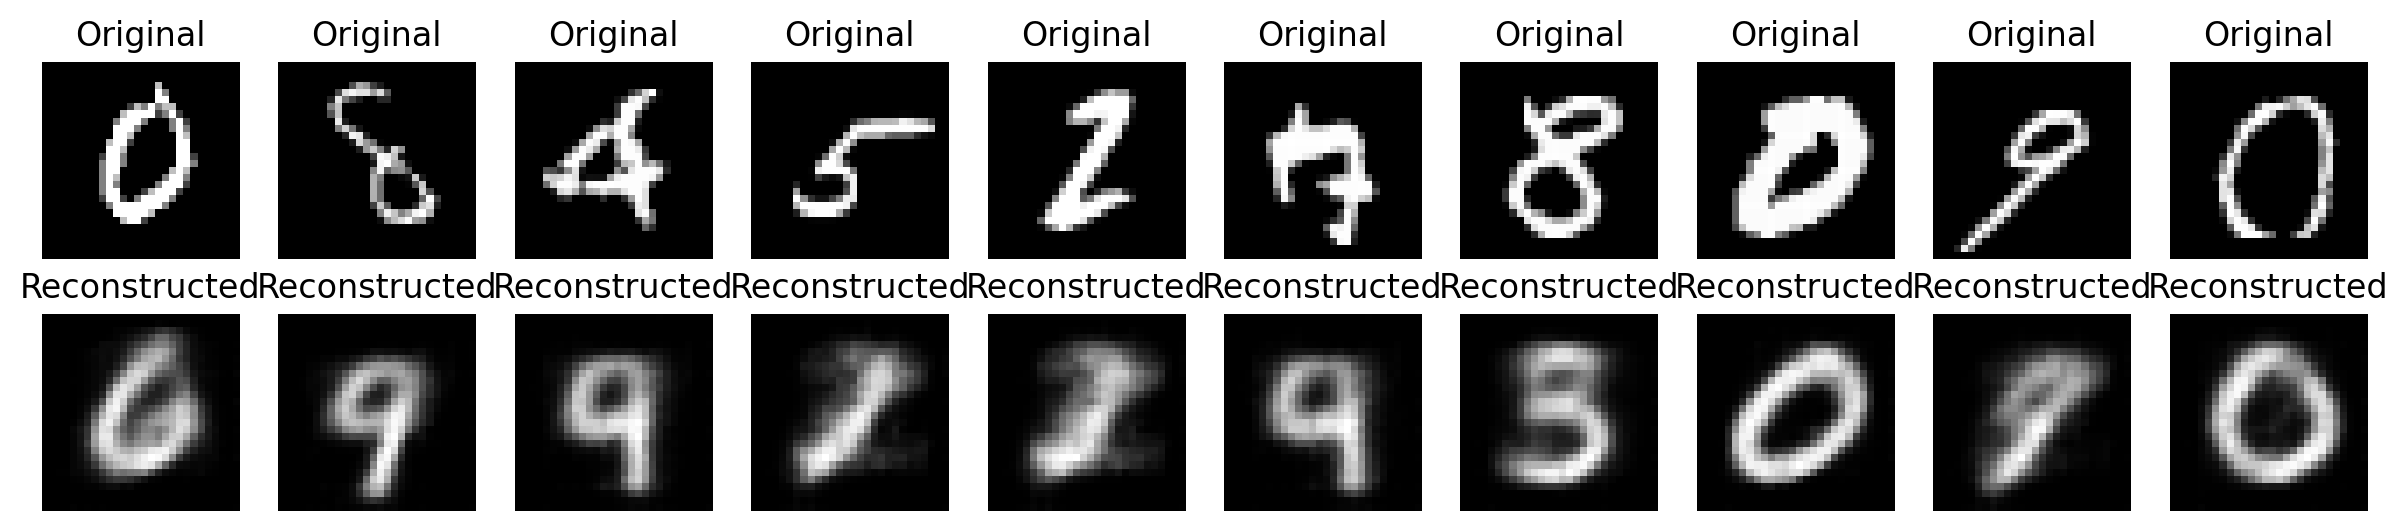

In [45]:
import matplotlib.pyplot as plt


def visualize_reconstruction(autoencoder, data, num_images=10):
    autoencoder.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(2, num_images, figsize=(15, 3))
        for i, (x, _) in enumerate(data):
            if i >= num_images:
                break
            x = x.to(device)
            x_hat = autoencoder(x)
            x_hat = x_hat.to("cpu").numpy()
            x = x.to("cpu").numpy()

            axes[0, i].imshow(x[0].reshape(28, 28), cmap="gray")
            axes[0, i].set_title("Original")
            axes[0, i].axis("off")

            axes[1, i].imshow(x_hat[0].reshape(28, 28), cmap="gray")
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis("off")

        plt.show()


visualize_reconstruction(vae, data)


In [1]:
import ipywidgets as widgets
from IPython.display import display

def interactive_plot(autoencoder, r0=(-5, 10), r1=(-10, 5)):
    def update(x=0.0, y=0.0):
        # Adjust the latent vector to match the expected dimensions
        z = torch.zeros((1, latent_dims)).to(device)
        z[0, :2] = torch.Tensor([x, y]).to(device)  # Assign x, y to the first two dimensions
        x_hat = autoencoder.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        plt.imshow(x_hat, extent=[*r0, *r1], cmap='gray')
        plt.axis('off')
        plt.show()

    x_slider = widgets.FloatSlider(value=0.0, min=r0[0], max=r0[1], step=0.1, description='X:')
    y_slider = widgets.FloatSlider(value=0.0, min=r1[0], max=r1[1], step=0.1, description='Y:')
    
    ui = widgets.VBox([x_slider, y_slider])
    out = widgets.interactive_output(update, {'x': x_slider, 'y': y_slider})
    
    display(ui, out)

interactive_plot(vae, r0=(-3, 3), r1=(-3, 3))


NameError: name 'vae' is not defined